## Code used for cleaning up and organizing the log results from MOA Multithread Ensembles

- Run ./chunk_pre.sh <Folder with chunk logs\> > file.csv
- Import and show
- Functions format_table_excel_* will either print (show) or (copy to) clipboard a df in the suggested format for annalysis

In [90]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import math
from IPython.display import display
from collections import Counter
pd.set_option('display.max_rows', 300)

**Preprocess logs**

In [2]:
%%bash
function create_csv {
    echo "arch,dataset,algorithm,ensemble_size,cores,chunk_size,time,accuracy,precision,recall" > data-$1.csv
    for i in $2
    do
        for j in $i/*
        do
            preprocess/preprocess.sh $j/ $1 0 >> data-$1.csv
        done
    done
}

function is_csv_complete {
    FILE=data-$1.csv
    if [[ -f "$FILE" ]]; then
        csv_entries=`cat data-$1.csv | wc -l`
    else
        csv_entries=0
    fi
    first_files=`ls $2/first/dump* | wc -l`
    second_files=`ls $2/second/dump* | wc -l`
    third_files=`ls $2/third/dump* | wc -l`
    sum_files=$(( $first_files + $second_files + $third_files ))
    if [[ $sum_files > $(( $csv_entries )) ]]; then
        echo "0"
    else
        echo "1"
    fi
}

function prep {
    # check  if the number of entries in csv equals the number of dump files in the folders
    is_complete=`is_csv_complete $1 $2`
    # if there are less entries than files 
    if [[ $is_complete == 0 ]]; then
        echo "creating data-${1}.csv!"
        create_csv $1 $2
    else
        echo "data-${1}.csv has all the entries for the files."
    fi
}

cd ../scripts
prep AMD ../results/AMD
prep Xeon ../results/journal/Xeon
prep Cloud ../results/Cloud
prep AMD-SCAL ../results/SCALE-AMD
prep seq-batch ../results/seq-batch

data-AMD.csv has all the entries for the files.
data-Xeon.csv has all the entries for the files.
data-Cloud.csv has all the entries for the files.
data-AMD-SCAL.csv has all the entries for the files.
data-seq-batch.csv has all the entries for the files.


ls: cannot access '../results/seq-batch/second/dump*': No such file or directory
ls: cannot access '../results/seq-batch/third/dump*': No such file or directory


**Preprocess i7 logs**

%%bash
cd ../scripts

echo "arch,eval,dataset,algorithm,ensemble_size,cores,chunk_size,time,accuracy,precision,recall" > data-i7.csv

for i in ../results/journal/*-i7
do
    for j in $i/*
    do
        preprocess/prepterm.sh $j/ i7 0 >> data-i7.csv
    done
done

**Aux methods**

In [3]:
def calcSP_UP():
    for i in ['GMSC', 'elecNormNew', 'airlines', 'covtypeNorm']:
        for j in ['ARF', 'LBag', 'OB', 'OBAdwin']:
            for k in ['CHUNK', 'MAXChunk']:
                if j+k in ndf[i]:
                    ndf[i, j+k+'-SPUP'] = ndf[i, j+'SEQ'] / ndf[i, j+k]
    ndf.sort_values(by=['dataset', 'algorithm'], axis=1, inplace=True)
    return ndf

In [4]:
def filter_by_substring_algorithm(df, string):
    ret = df[df['algorithm'].str.contains(string, regex=False)]
    if string == 'OB':
        ret = ret[~ret.algorithm.str.contains("Adwin|ASHT")]
    return ret

In [5]:
def group_by(df, columns=['dataset','algorithm','ensemble_size','chunk_size']):
    return df.groupby(columns, as_index=False).mean()

In [6]:
def filter_by_alg(df, all_algs=False):
    import re
    if all_algs:
        lst = ['Sequential', 'RUNPER', 'MB', 'MB+']
    else:
        lst = ['Sequential', 'RUNPER', 'MB+']
    esc_lst = [re.escape(s) for s in lst]
    pattern = '|'.join(esc_lst)
    mask = df['algorithm'].str.contains(pattern, case=True)
    return df[mask]

In [7]:
def pivot(df, col='time'):
    return df.round(2).pivot_table(values=col,
                                   index=['ensemble_size', 'chunk_size'],
                                   columns=['dataset','algorithm'],
                                   aggfunc='first')

In [8]:
def gen_bar_2_series(values_100, values_150, ax, ylim=-1, all_algs=True):
    if all_algs:
        labels = ['Seq', 'Par', 'MB50', 'MB500', 'MB2k', 'MB+50', 'MB+500', 'MB+2k']
    else:
        labels = ['Seq', 'PB1', 'PB50', 'PB500', 'PB2k']
    x = np.arange(len(labels))/2
    width = 0.20  # the width of the bars
    rects1 = ax.bar(x - width/2, values_100, width, label='E100')
    rects2 = ax.bar(x + width/2, values_150, width, label='E150')
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    if ylim != -1:
        ax.set_ylim(0, ylim)
    ax.legend()

In [9]:
def gen_bar_4_series(values_100, values_150, v100, v150, ax, ylim=-1, all_algs=False, legend=True):
    if all_algs:
        labels = ['Seq', 'Par', 'MB50', 'MB500', 'MB2k', 'MB+50', 'MB+500', 'MB+2k']
    else:
        labels = ['Seq', 'PB1', 'PB50', 'PB500', 'PB2k']
    x = np.arange(len(labels))
    width = 0.20  # the width of the bars
    rects1 = ax.bar(x - 3*width/2, values_100, width, label='X-E100')
    rects2 = ax.bar(x - width/2, values_150, width, label='X-E150')
    rects3 = ax.bar(x + width/2, v100, width, label='I-E100')
    rects4 = ax.bar(x + 3*width/2, v150, width, label='I-E150')
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    if ylim != -1:
        ax.set_ylim(0, ylim)
    if legend:
        ax.legend(loc=2)

In [10]:
def get_lst(df, alg, all_algs=False):
    if all_algs:
        suff = {'Sequential': [1], 'RUNPER': [1], 'MB': [50, 500, 2000], 'MB+': [50, 500, 2000]}
    else:
        suff = {'Sequential': [1], 'RUNPER': [1], 'MB+': [50, 500, 2000]}
    size = [100, 150]
    ret = {100: [], 150: []}
    for s in size:
        for k in suff.keys():
            for i in suff[k]:
                ret[s].append(df[alg+k][s][i])
    return ret[100], ret[150]

In [11]:
def select_columns_and_rename_values(df):
    df = df.loc[:,['dataset', 'algorithm', 'ensemble_size', 'cores', 'chunk_size', 'time', 'accuracy']]
    df['algorithm'] = df["algorithm"].str.replace("Executor", "")
    df['algorithm'] = df["algorithm"].str.replace("OzaBag", "OB")
    df['algorithm'] = df["algorithm"].str.replace("AdaptiveRandomForest", "ARF")
    df['algorithm'] = df["algorithm"].str.replace("SequentialChunk", "SeqMB")
    df['algorithm'] = df["algorithm"].str.replace("OB$", "OBSequential")
    df['algorithm'] = df["algorithm"].str.replace("ARF$", "ARFSequential")
    df['algorithm'] = df['algorithm'].str.replace("LeveragingBag", "LBagSequential")
    df['algorithm'] = df['algorithm'].str.replace("Adwin$", "AdwinSequential")
    df['algorithm'] = df['algorithm'].str.replace("CHUNK", "MB")
    df['algorithm'] = df['algorithm'].str.replace("MAXChunk", "MB+")
    df['algorithm'] = df['algorithm'].str.replace("StreamingRandomPatches", "SRP")
    df['algorithm'] = df['algorithm'].str.replace("SRP$", "SRPSequential")
    df['algorithm'] = df['algorithm'].str.replace("OBASHT$", "OBASHTSequential")
    return df

In [12]:
def get_delay(lst, ninst, miliseconds=False):
    for i in range(len(lst)):
        lst[i] = (lst[i]/ninst)
    if miliseconds:
        lst *= 1000
    return lst

def get_vazao(lst, ninst):
    for i in range(len(lst)):
        lst[i] = ninst/lst[i]
    return lst

def get_sf(lst):
    for i in range(1,len(lst),1):
        lst[i] = lst[0]/lst[i]
    lst[0] = 1
    return lst

In [13]:
def gen_graph_bars(df, datasets, algs, ninst, arch, TPUT=False, DELAY=False, SF=False, all_algs=False):
    fig, axs = plt.subplots(len(datasets), len(algs), figsize=(18,14), sharey='row')
    filename = arch
    df = group_by(filter_by_alg(df, all_algs))
    for ds in datasets:
        title = ''
        for i in algs:
            d100,d150 = get_lst(pivot(filter_by_substring_algorithm(df, i))[ds], i, all_algs)
            if DELAY:
                d100 = get_delay(d100, ninst[ds])
                d150 = get_delay(d150, ninst[ds])
                title += 'Avg processing time/instance(s)'
            elif TPUT:
                d100 = get_vazao(d100, ninst[ds])
                d150 = get_vazao(d150, ninst[ds])
                title += 'Throughput instances/second(ms)'
            elif SF:
                d100 = get_sf(d100)
                d150 = get_sf(d150)
                title += 'Scale Factor (Speed Up)'
            ax = axs[datasets.index(ds)][algs.index(i)]
            gen_bar_2_series(d100, d150, ax, all_algs=all_algs)
            if i == 'ARF':
                ax.set_ylabel(f'{ds.title()}\n{title}')
            if ds == 'airlines':
                ax.set_title(f'{i}')
    if DELAY:
        filename+='-procTimePerInst'
    elif TPUT:
        filename+='-throughput'
    elif SF:
        filename+='-scalefactor'
    else:
        filename+='-walltime'
    fig.tight_layout()
    plt.savefig(f'{filename}.png')

In [14]:
def gen_graph_bars_BOTHARCH(dfX, dfI, datasets, algs, ninst, archX, archI, TPUT=False, DELAY=False, SF=False, all_alg=False):
    fig, axs = plt.subplots(len(datasets), len(algs), figsize=(18,14), sharey='row')
    filename = f"{archX}-{archI}"
    dfX = group_by(filter_by_alg(dfX, all_alg))
    dfI = group_by(filter_by_alg(dfI, all_alg))
    legend=True
    for ds in datasets:
        title = ''
        for i in algs:
            xd100,xd150 = get_lst(pivot(filter_by_substring_algorithm(dfX, i))[ds], i, all_alg)
            id100,id150 = get_lst(pivot(filter_by_substring_algorithm(dfI, i))[ds], i, all_alg)
            if DELAY:
                xd100 = get_delay(xd100, ninst[ds])
                xd150 = get_delay(xd150, ninst[ds])
                id100 = get_delay(id100, ninst[ds])
                id150 = get_delay(id150, ninst[ds])
                title += 'Avg processing time/instance(s)'
            elif TPUT:
                xd100 = get_vazao(xd100, ninst[ds])
                xd150 = get_vazao(xd150, ninst[ds])
                id100 = get_vazao(id100, ninst[ds])
                id150 = get_vazao(id150, ninst[ds])
                title += 'Throughput instances/second(ms)'
            elif SF:
                xd100 = get_sf(xd100)
                xd150 = get_sf(xd150)
                id100 = get_sf(id100)
                id150 = get_sf(id150)
                title += 'Speed Up'
            ax = axs[datasets.index(ds)][algs.index(i)]
            gen_bar_4_series(xd100, xd150, id100, id150, ax, all_algs=all_alg,legend=legend)
            legend=False
            if i == algs[0]:
                ax.set_ylabel(f'{ds.title()}\n{title}')
            if ds == 'airlines':
                ax.set_title(f'{i}')
    if DELAY:
        filename+='-procTimePerInst'
    elif TPUT:
        filename+='-throughput'
    elif SF:
        filename+='-scalefactor'
    else:
        filename+='-walltime'
    fig.tight_layout()
    plt.savefig(f'{filename}.eps')
    plt.savefig(f'{filename}.png')

In [32]:
def load_df(filename):
    df = pd.read_csv(filename)
    return select_columns_and_rename_values(df)

%cd ../scripts
dfxe = load_df('data-Xeon.csv')
dfi7 = load_df('data-i7.csv')
dfAMD = load_df('data-AMD.csv')
dfcl = load_df('data-Cloud.csv')

/home/cassales/Documents/Parallel-Classifier-MOA/scripts


In [16]:
datasets = ['airlines', 'GMSC', 'elecNormNew', 'covtypeNorm']
algs = ['ARF', 'LBag', 'OBAdwin', 'OB']
ninst = {'airlines': 540000, 'GMSC': 150000, 'elecNormNew': 45000, 'covtypeNorm':  581000}
arch ='Xeon'

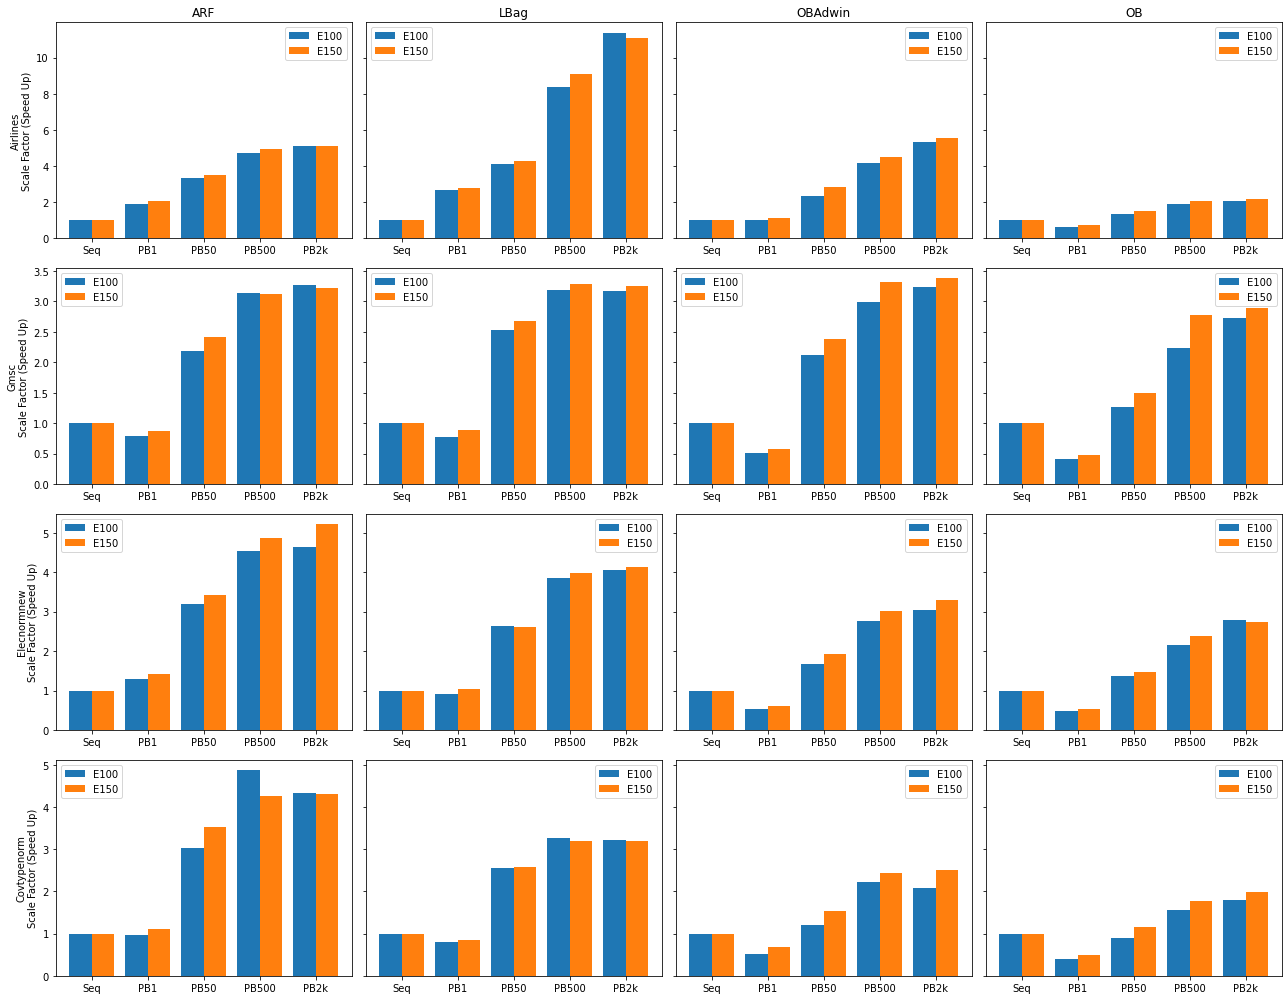

In [17]:
gen_graph_bars(dfxe, datasets, algs, ninst, 'Xeon', SF=True, all_algs=False)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


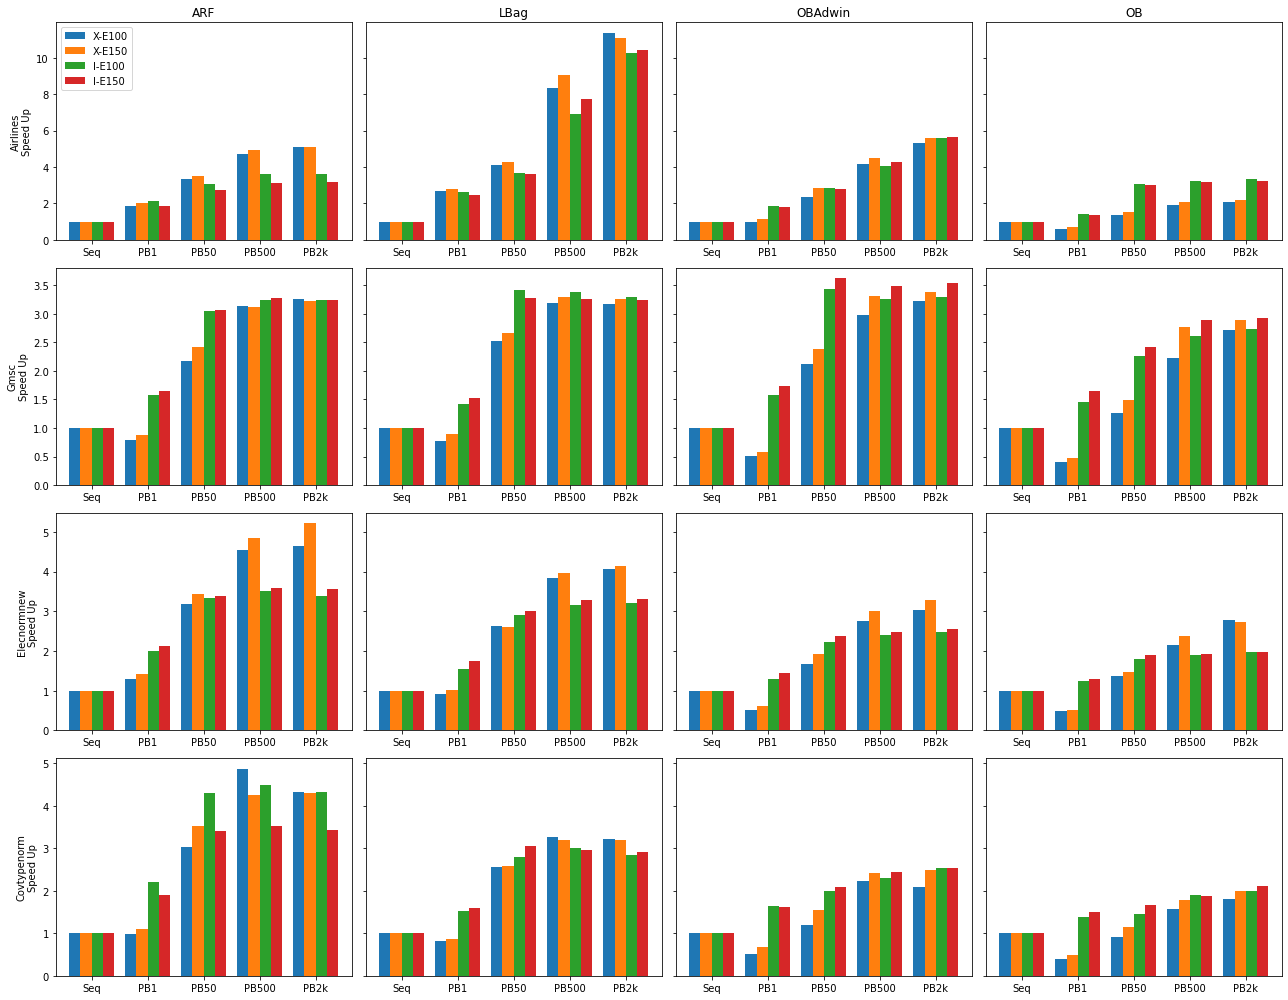

In [18]:
gen_graph_bars_BOTHARCH(dfxe, dfi7, datasets, algs, ninst, 'Xeon', 'i7', SF=True, all_alg=False)

## New algorithms

In [19]:
samd = set(dfAMD.algorithm.unique())
scl = set(dfcl.algorithm.unique())
sxe = set(dfxe.algorithm.unique())
print(samd == scl, samd == sxe)

True True


In [20]:
def gen_bar_2_series(values_100, values_150, ax, ylim=-1, all_algs=True):
    if all_algs:
        labels = ['Seq', 'Par', 'MB50', 'MB500', 'MB2k', 'MB+50', 'MB+500', 'MB+2k']
    else:
        labels = ['Seq', 'Par', 'MB+50', 'MB+500', 'MB+2k']
    
    x = np.arange(len(labels))/2
    width = 0.15  # the width of the bars
    rects1 = ax.bar(x - width/2, values_100, width, label='E100')
    rects2 = ax.bar(x + width/2, values_150, width, label='E150')
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    if ylim != -1:
        ax.set_ylim(0, ylim)
    ax.legend()

In [21]:
def gen_lines_2_series_label(values_100, values_150, ax, ylim=-1, all_algs=True, label='', legend=False, arch_order=0):
    if all_algs:
        labels = ['Seq', 'Par', 'MB50', 'MB500', 'MB2k', 'MB+50', 'MB+500', 'MB+2k']
    else:
        labels = ['Seq', 'B1', 'B50', 'B500', 'B2k']
    colors=['go', 'bs', 'rP', 'md', 'y+' , 'k*']
    x = np.arange(len(labels))/2
    width = 0.15  # the width of the bars
    rects1 = ax.plot(x, values_100, f'{colors[arch_order]}-', label=f'{label}-100')
    rects2 = ax.plot(x, values_150, f'{colors[arch_order]}--', label=f'{label}-150')
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    if ylim != -1:
        ax.set_ylim(0, ylim)
    if legend:
        ax.legend()

In [22]:
def gen_graph_lines_lists(incdf, datasets, algs, ninst, arch, TPUT=False, DELAY=False, SF=False, all_algs=False, in_sharey='row'):
    fig, axs = plt.subplots(len(datasets), len(algs), figsize=(18,14), sharey=in_sharey)
    filename = ''
    for a in arch:
        filename += f'{a}-'
    gdf = [group_by(filter_by_alg(i, all_algs)) for i in incdf]
    dsformalname = {'elecNormNew': 'Electricity', 'GMSC': 'GMSC', 'airlines': 'Airlines', 'covtypeNorm': 'Covertype'}
    for ds in datasets:
        title = ''
        for i in algs:
            if i == algs[0] and ds == datasets[0]:
                legend_chart = True
            else:
                legend_chart = False
            for index in range(len(gdf)):
                d100,d150 = get_lst(pivot(filter_by_substring_algorithm(gdf[index], i))[ds], i, all_algs)
                if DELAY:
                    d100 = get_delay(d100, ninst[ds])
                    d150 = get_delay(d150, ninst[ds])
                    title += 'Avg processing time/instance(s)'
                elif TPUT:
                    d100 = get_vazao(d100, ninst[ds])
                    d150 = get_vazao(d150, ninst[ds])
                    title += 'Throughput instances/second(ms)'
                elif SF:
                    d100 = get_sf(d100)
                    d150 = get_sf(d150)
                    title += 'Scale Factor (Speed Up)'
                ax = axs[datasets.index(ds)][algs.index(i)]
                gen_lines_2_series_label(d100, d150, ax, all_algs=all_algs, label=arch[index], legend=legend_chart, arch_order=index)
                if i == 'LBag' and index == 0:
                    ax.set_ylabel(f'{dsformalname[ds]}\n{title}')
                if ds == 'airlines':
                    if index == 0:
                        ax.set_title(f'{i}')
                else:
                    ax.set_ylim(0,8)
    if DELAY:
        filename+='procTimePerInst'
    elif TPUT:
        filename+='throughput'
    elif SF:
        filename+='scalefactor'
    else:
        filename+='walltime'
    fig.tight_layout()
    plt.savefig(f'{filename}-sharey_{in_sharey}.png')
    plt.savefig(f'{filename}-sharey_{in_sharey}.eps')

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


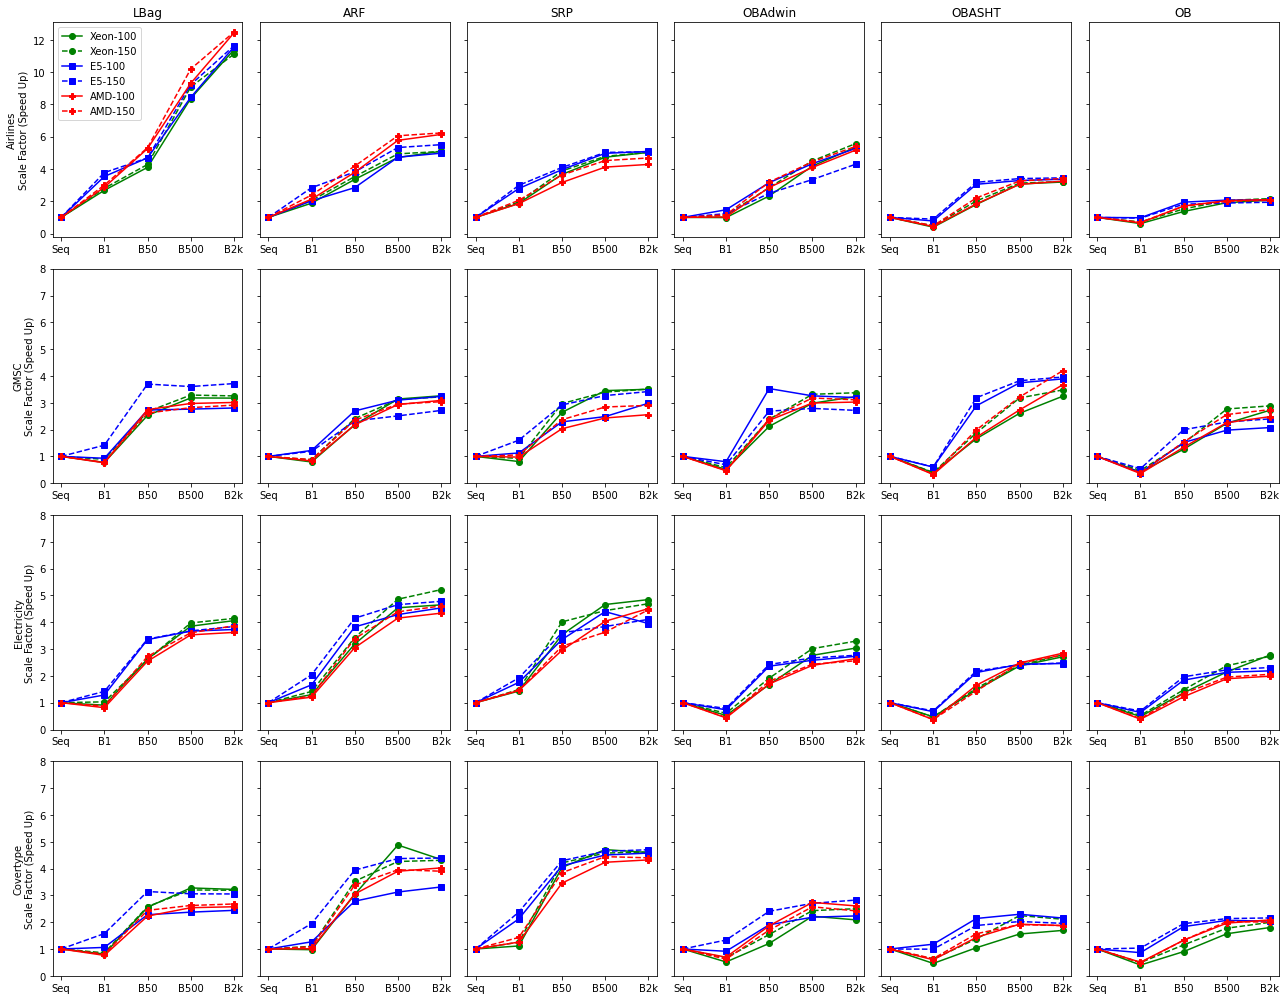

In [23]:
datasets = ['airlines', 'GMSC', 'elecNormNew', 'covtypeNorm']
algs = ['LBag', 'ARF', 'SRP', 'OBAdwin', 'OBASHT', 'OB']
ninst = {'airlines': 540000, 'GMSC': 150000, 'elecNormNew': 45000, 'covtypeNorm':  581000}
gen_graph_lines_lists([dfxe, dfcl, dfAMD], datasets, algs, ninst, ['Xeon', 'E5', 'AMD'], SF=True, all_algs=False)

In [28]:
# gen_graph_lines_lists([dfxe, dfAMD, dfcl], datasets, algs, ninst, ['Xeon', 'AMD', 'Cloud'], SF=True, all_algs=False, in_sharey='all')

In [83]:
def gen_lines_2_series_label_parallel(values_100, values_150, ax, ylim=-1, all_algs=True, label='', legend=False, arch_order=0):
    labels = ['    Sequential', 'Parallel         ']
    colors=['go', 'bs', 'rP', 'md', 'y+' , 'k*']
    x = np.arange(len(labels))/2
    width = 0.15  # the width of the bars
#     print(values_100, values_100[:2])
    rects1 = ax.plot(x, values_100[:2], f'{colors[arch_order]}-', label=f'{label}-100')
    rects2 = ax.plot(x, values_150[:2], f'{colors[arch_order]}--', label=f'{label}-150')
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    if ylim != -1:
        ax.set_ylim(0, ylim)
    if legend:
        ax.legend()

In [98]:
def gen_graph_lines_lists_parallel(incdf, datasets, algs, ninst, arch, TPUT=False, DELAY=False, SF=False, all_algs=False, in_sharey='row'):
    fig, axs = plt.subplots(len(datasets), len(algs), figsize=(14,6), sharey=in_sharey)
    filename = ''
    for a in arch:
        filename += f'{a}-'
#     display(incdf)
    gdf = [group_by(filter_by_alg(i, all_algs)) for i in incdf]
#     print(gdf)
    dsformalname = {'elecNormNew': 'Electricity', 'GMSC': 'GMSC', 'airlines': 'Airlines', 'covtypeNorm': 'Covertype'}
    for ds in datasets:
        title = ''
        for i in algs:
            for index in range(len(gdf)):
#                 display(filter_by_substring_algorithm(gdf[index], i))
                d100,d150 = get_lst(pivot(filter_by_substring_algorithm(gdf[index], i))[ds], i, all_algs)
                if DELAY:
                    d100 = get_delay(d100, ninst[ds])
                    d150 = get_delay(d150, ninst[ds])
                    title += 'Avg processing time/instance(s)'
                elif TPUT:
                    d100 = get_vazao(d100, ninst[ds])
                    d150 = get_vazao(d150, ninst[ds])
                    title += 'Throughput instances/second(ms)'
                elif SF:
                    d100 = get_sf(d100)
                    d150 = get_sf(d150)
                    title += 'Speed Up'
                ax = axs[datasets.index(ds)][algs.index(i)]
                gen_lines_2_series_label_parallel(d100, d150, ax, all_algs=all_algs, label=arch[index], legend=False, arch_order=index)
                if i == 'LBag' and index == 0:
                    ax.set_ylabel(f'{dsformalname[ds]}\n{title}')
                if ds == 'airlines':
                    if index == 0:
                        ax.set_title(f'{i}')
                if index == 0:
                    ax.set_ylim(0,4)
#                 else:
#                     ax.set_ylim(0,4)
    if DELAY:
        filename+='procTimePerInst'
    elif TPUT:
        filename+='throughput'
    elif SF:
        filename+='scalefactor'
    else:
        filename+='walltime'
        
        
    handles, labels = axs[0][0].get_legend_handles_labels()
    lgd = fig.legend(handles, labels, loc = 'lower center', ncol = math.ceil(len(algs)), bbox_to_anchor=(0.5,-0.1))
    fig.tight_layout()
    plt.savefig(f'{filename}-sharey_{in_sharey}-parallel.png')
    plt.savefig(f'{filename}-sharey_{in_sharey}-parallel.eps')

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


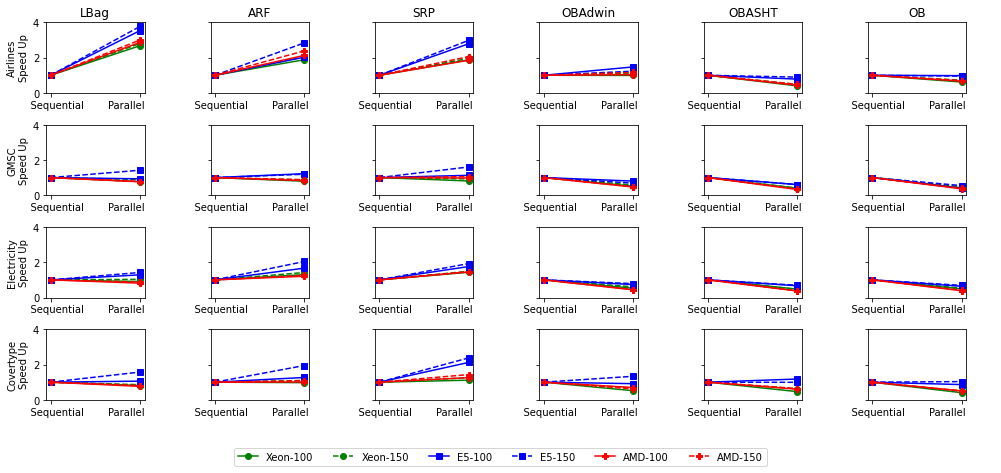

In [99]:
datasets = ['airlines', 'GMSC', 'elecNormNew', 'covtypeNorm']
algs = ['LBag', 'ARF', 'SRP', 'OBAdwin', 'OBASHT', 'OB']
ninst = {'airlines': 540000, 'GMSC': 150000, 'elecNormNew': 45000, 'covtypeNorm':  581000}
gen_graph_lines_lists_parallel([dfxe, dfcl, dfAMD], datasets, algs, ninst, ['Xeon', 'E5', 'AMD'], SF=True, all_algs=False)

In [ ]:
def gen_table_exec_times(incdf, datasets, algs, arch, all_algs=False):
    filename = ''
    for a in arch:
        filename += f'{a}-'
    gdf = [group_by(filter_by_alg(i, all_algs)) for i in incdf]
    dsformalname = {'elecNormNew': 'Electricity', 'GMSC': 'GMSC', 'airlines': 'Airlines', 'covtypeNorm': 'Covertype'}
    d = {}
    datacolumn = ['Airlines', 'Airlines', 'Airlines', 'Airlines', 'GMSC', 'GMSC', 'GMSC', 'GMSC', 'Electricity', 'Electricity', 
                  'Electricity', 'Electricity', 'Covertype', 'Covertype', 'Covertype', 'Covertype']
    for index in range(len(gdf)):
        title = ''
        d[index] = {}
        dnow = d[index]
        dnow['dataset'] = datacolumn
        dnow['size'] = ['B1', 'B50', 'B500', 'B2k']*4
        for ds in datasets:
            for i in algs:
                if f'{i}-100' not in dnow:
                    dnow[f'{i}-100'] = []
                    dnow[f'{i}-150'] = []
                d100,d150 = get_lst(pivot(filter_by_substring_algorithm(gdf[index], i))[ds], i, all_algs)
                dnow[f'{i}-100'] += d100[1:]
                dnow[f'{i}-150'] += d150[1:]
    print(d)
    for k, v in d.items():
        novodf = pd.DataFrame.from_dict(v)
        print(novodf.dtypes)
        novodf.to_csv(f'{arch[k]}.csv', index=False, float_format='%.2f')

In [ ]:
# gen_table_exec_times([dfxe, dfcl, dfAMD], datasets, algs, ['Silver', 'E5', 'AMD'], all_algs=False)

#
#
#
#
#
#
#
#
# ENERGI RATE

In [ ]:
dfxe = dfxe[(dfxe.ensemble_size == 100) & (dfxe.chunk_size != 50) & (dfxe.chunk_size != 2000)].rename(columns={'chunk_size': 'batch_size'})

In [ ]:
def calculate_rate(desired_esize, df):
    algorithms = ['ARF', 'LBag', 'SRP', 'OBAdwin', 'OBASHT', 'OB']
    file_algs = {'ARF': 'ARF', 'LBag': 'LBag', 'SRP': 'SRP', 'OBAdwin': 'OBagAd', 'OBASHT':'OBagASHT', 'OB': 'OBag'}
    for ds in df.dataset.unique():
        dsdf = df[df.dataset == ds]
        for alg in algorithms:
            s = f'X $1{ds}.arff {file_algs[alg]}'
            adf = filter_by_substring_algorithm(dsdf, alg)
#             if alg == 'SRP':
#                 display(adf)
            dfres = adf[adf.ensemble_size == desired_esize]
#             display(dfres)
            # get sequential
            seq_rate = list((dfres[(dfres.batch_size == 1) & (dfres.cores == 1)].IPS))[0]
            # get runper
            runper_rate = list(dfres[(dfres.batch_size == 1) & (dfres.cores == 8)].IPS)[0]
            # get MB
            mb_rate = list(dfres[(dfres.batch_size == 500) & (dfres.cores == 8)].IPS)[0]
            #we have max rates, now we need 10, 50 and 90
            if mb_rate != 'NaN':
                #10
                print(f'{s} {int(0.9*seq_rate)} {int(0.9*runper_rate)} {int(0.9*mb_rate)}')
                #50
                print(f'{s} {int(0.5*seq_rate)} {int(0.5*runper_rate)} {int(0.5*mb_rate)}')
                #90
                print(f'{s} {int(0.1*seq_rate)} {int(0.1*runper_rate)} {int(0.1*mb_rate)}')

In [ ]:
ninst = {'airlines': 540000, 'GMSC': 150000, 'elecNormNew': 45000, 'covtypeNorm':  581000}
cu = dfxe.groupby(['dataset', 'algorithm', 'ensemble_size', 'cores', 'batch_size'], as_index=False).mean()
cu['IPS'] = 0
for ds in  ninst.keys():
    cu.loc[cu.dataset == ds,'IPS'] = ninst[ds]/cu.loc[cu.dataset == ds,'time']

calculate_rate(100, cu)

#
#
#
#
#
#
#
#
# SCALABILTY

In [ ]:
dfSCAL = load_df('data-AMD-SCAL.csv')
dfSCAL

In [ ]:
def pivot_scale(df, col='time'):
    return df.round(2).pivot_table(values=col,
                                   index=['ensemble_size', 'chunk_size','cores'],
                                   columns=['dataset','algorithm'],
                                   aggfunc=np.mean)

In [ ]:
def group_by_scale(df):
    return df.groupby(['dataset','algorithm','ensemble_size','chunk_size','cores'], as_index=False).mean()

In [ ]:
def gen_lines_2_series_scale(values_50, values_1, ax, ylim=-1, all_algs=True, labels=[]):
    x = np.arange(len(labels))
    width = 0.15  # the width of the bars
    rects1 = ax.plot(x, values_50, label=f'B50')
    rects2 = ax.plot(x, values_1, label=f'B1')
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    if ylim != -1:
        ax.set_ylim(0, ylim)
    ax.legend()

In [ ]:
def get_scalability(df, alg):
    version = [50, 1]
    ret = {50: [], 1: []}
    labels = sorted(df.cores.unique())
    baseline = df[(df.chunk_size == 1) & (df.cores == 1)].time.values[0]
    for v in version:
        ret[v].append(baseline)
    for cores in labels[1:]:
        for v in version:
            ret[v].append( df[(df.chunk_size == v) & (df.cores == cores)].time.values[0] )
    return ret[50], ret[1], labels

In [ ]:
def gen_graph_scale(df, datasets, algs, ninst, arch, TPUT=False, DELAY=False, SF=False, all_algs=False):
    fig, axs = plt.subplots(len(datasets), len(algs), figsize=(18,10), sharey='row')
    filename = f'scalability-{arch}'
    df = group_by_scale(filter_by_alg(df, all_algs))
    for ds in datasets:
        title = ''
        DSdf = df[df.dataset == ds]
        for i in algs:
            b50, b1, labels = get_scalability(filter_by_substring_algorithm(DSdf, i), i)
            if SF:
                b50 = get_sf(b50)
                b1 = get_sf(b1)
                title += 'Speed Up'
            ax = axs[datasets.index(ds)][algs.index(i)]
            gen_lines_2_series_scale(b50, b1, ax, all_algs=all_algs, labels=labels)
            if i == 'LBag':
                ax.set_ylabel(f'{ds.title()}\n{title}')
            if ds == 'airlines':
                ax.set_title(f'{i}')
    if DELAY:
        filename+='-procTimePerInst'
    elif TPUT:
        filename+='-throughput'
    elif SF:
        filename+='-scalefactor'
    else:
        filename+='-walltime'
    fig.tight_layout()
    plt.savefig(f'{filename}.png')

In [ ]:
datasetsB = ['airlines', 'elecNormNew']
algs = ['LBag', 'ARF', 'SRP', 'OBAdwin', 'OBASHT', 'OB']
ninst = {'airlines': 540000, 'GMSC': 150000, 'elecNormNew': 45000, 'covtypeNorm':  581000}
gen_graph_scale(dfSCAL, datasetsB, algs, ninst, 'AMD', SF=True, all_algs=False)

#
#
#
#
#
#
#
#
# SEQUENTIAL BATCH

In [ ]:
dfSB = load_df('data-seq-batch.csv')
dfSB.head()

In [ ]:
algseries = dfxe.algorithm
mask = []
for a in algseries:
    if 'Sequential' in a:
        flag = True
    else:
        flag = False
    mask.append(flag)
seqalg = dfxe[mask]
seqalg = seqalg[['dataset', 'algorithm', 'ensemble_size','cores', 'time','accuracy']]

In [ ]:
dfLast = pd.concat([dfSB, seqalg]).sort_values(by=['dataset', 'algorithm', 'ensemble_size', 'chunk_size'])
dfLast['chunk_size'] = dfLast['chunk_size'].fillna(1)
dfLast = dfLast.groupby(['dataset', 'algorithm', 'ensemble_size', 'cores', 'chunk_size'], as_index=False).mean()
dfLast

In [ ]:
def gen_lines_label(values_100, ax, ylim=-1, label='', legend=False, alg_order=0):
    labels = ['SB1', 'SB50', 'SB500', 'SB2k']
    colors=['go', 'bs', 'rP', 'md', 'y+' , 'k*']
    lwidth = 1.25
    x = np.arange(len(labels))
    line1 = ax.plot(x, values_100, f'{colors[alg_order]}-', label=f'{label}-100', linewidth=lwidth)
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    if ylim != -1:
        ax.set_ylim(0.85, ylim)
    if legend:
        ax.legend()

In [ ]:
def gen_graph_lines_SB(df, datasets, algs, ninst, arch, SF=False):
    fig, axs = plt.subplots(2, 2, figsize=(10,8), sharey='row')
    filename = f'{arch}-SB'
    df = group_by(df)
    labels = ['SB1', 'SB50', 'SB500', 'SB2k']
    dsformalname = {'elecNormNew': 'Electricity', 'GMSC': 'GMSC', 'airlines': 'Airlines', 'covtypeNorm': 'Covertype'}
    for ds in datasets:
        title = ''
        col = (datasets.index(ds) % 2)
        lin = int(datasets.index(ds)/2)
        ax = axs[lin][col]
        ax.set_title(f'{dsformalname[ds]}\n{title}')
        if col == 0:
            ax.set_ylabel(f'Speed Up')
        if lin == 1:
            ax.set_xlabel('Batch size')
        for i in algs:
            d100 = get_lst_SB(pivot(filter_by_substring_algorithm(df, i))[ds], i)
            if SF:
                d100 = get_sf(d100)
                title += 'Speed Up'
            gen_lines_label(d100, ax, ylim=3.5, alg_order=algs.index(i), label=i)
        ax.axhline(y=1.2, color='b', linestyle=':')
        ax.axhline(y=1.0, color='r', linestyle=':')
    if SF:
        filename+='-speedup'
    else:
        filename+='-walltime'
   
    lines,labels2 = axs[0][0].get_legend_handles_labels()
    lgd = fig.legend(lines,labels2, ncol = 6, loc = 'lower center', bbox_to_anchor=(0.5, -0.05))
    fig.tight_layout()
    plt.savefig('SPUP-sequential-MB.eps', bbox_extra_artists=(lgd,), bbox_inches='tight')

In [ ]:
def get_lst_SB(df, alg):
    suff = {'Sequential': [1], 'SeqMB': [50, 500, 2000]}
    size = [100]
    ret = {100: []}
    for s in size:
        for k in suff.keys():
            for i in suff[k]:
                ret[s].append(df[alg+k][s][i])
    return ret[100]

In [ ]:
algsB = ['LBag', 'ARF', 'SRP', 'OBAdwin', 'OBASHT', 'OB']
ninst = {'airlines': 540000, 'GMSC': 150000, 'elecNormNew': 45000, 'covtypeNorm':  581000}
gen_graph_lines_SB(dfLast, datasets, algsB, ninst, 'Xeon', SF=True)

In [ ]:
#dfLast[dfLast.ensemble_size == 100].sort_values(['dataset', 'algorithm', 'chunk_size'])